In [1]:
import functools
import glob
import itertools
import json
import operator
import os
import re
import string
import xml.etree.ElementTree as ET
from collections import Counter, namedtuple, defaultdict

import matplotlib.pyplot as plt
import nltk
import numpy as np
import requests
from bs4 import BeautifulSoup
import gensim.models as gm
from sklearn.manifold import TSNE

E:\Program Files\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
PATH = 'F:\\saos\\data\\json\\judgments-*'
CORPUS_DIR = 'texts2'
MODEL_NAME = 'model3'

In [3]:
def get_judgment_texts(filename):
    with open(filename, encoding='utf-8') as file:
        content = json.load(file)
    return (clear_text(item['textContent']) for item in content['items'])


def clear_text(text: str):
    html_clear_text = BeautifulSoup(text, 'lxml').get_text()
    return re.sub('-\n', '', html_clear_text)


def file_number(filename):
    hyphen_index = filename.find('-')
    dot_index = filename.find('.')
    return int(filename[hyphen_index:dot_index])

In [4]:
if not os.path.exists(CORPUS_DIR):
    all_judgment_filenames = sorted(glob.glob(PATH), key=file_number)
    texts = itertools.chain.from_iterable(map(get_judgment_texts, all_judgment_filenames))
    for index, text in enumerate(texts):
        words = (token for token in nltk.word_tokenize(text, language='polish') if token not in string.punctuation)
        with open(os.path.join(CORPUS_DIR, f'{index}.txt'), 'w', encoding='utf-8') as file:
            file.write(' '.join(words))
        print(index)
        if index > 60000:  # should be more than 1 GB of texts
            break

In [19]:
def train_model():
    sentences = gm.word2vec.PathLineSentences(CORPUS_DIR)
    phrases = gm.phrases.Phrases(sentences, delimiter=b' ')
    bigram = gm.phrases.Phraser(phrases)
    trigram = gm.phrases.Phrases(bigram[sentences], delimiter=b' ')
    phraser = gm.phrases.Phraser(trigram)
    model = gm.word2vec.Word2Vec(phraser[sentences], sg=0, window=5, size=300, min_count=3, workers=16)
    model.save(MODEL_NAME)
    
if not os.path.exists(MODEL_NAME):
    train_model()

In [20]:
model = gm.word2vec.Word2Vec.load(MODEL_NAME)

In [21]:
expressions = (
    'Sąd Najwyższy',
    'Trybunał Konstytucyjny',
    'kodeks cywilny',
    'kpk',
    'sąd rejonowy',
    'szkoda',
    'wypadek',
    'kolizja',
    'szkoda majątkowa',
    'nieszczęście',
    'rozwód'
)
for expression in expressions:
    print(expression)
    similar_expressions = model.wv.most_similar(positive=expression)
    for phrase, score in similar_expressions[:3]:
        print(phrase, score)
    print()

Sąd Najwyższy
Sad Najwyższy 0.7552286982536316
Trybunał Konstytucyjny 0.7463752031326294
Trybunał 0.6924906969070435

Trybunał Konstytucyjny
Trybunał 0.8502930402755737
Trybunał Sprawiedliwości 0.7915868759155273
TSUE 0.7716569900512695

kodeks cywilny
Kodeks cywilny 0.7345961332321167
kodeks karny 0.7077544927597046
ustawa ta 0.6570603847503662

kpk
k.p.k 0.9305874705314636
k.p.k. 0.9046614766120911
KPK 0.807941734790802

sąd rejonowy
sąd meriti 0.9072951078414917
Sąd meriti 0.8900603652000427
sąd okręgowy 0.8645068407058716

szkoda
szkoda ta 0.7602248191833496
szkoda majątkowa 0.7396939992904663
Szkoda 0.6842246055603027

wypadek
przypadek 0.5461269021034241
skutek 0.5364439487457275
przedmiotowy wypadek 0.5290244817733765

kolizja
kolizja drogowa 0.736346960067749
usterka 0.693447470664978
awaria 0.6833497285842896

szkoda majątkowa
szkoda 0.7396939992904663
krzywda 0.7171034812927246
szkoda ta 0.6987612247467041

nieszczęście
symptomy wskazywały 0.6347035765647888
odblaskową 0.6209

In [22]:
operations = (
    (['Sąd Najwyższy', 'konstytucja'], ['kpc']),
    (['pasażer', 'kobieta'], ['mężczyzna']),
    (['samochód', 'rzeka'], ['droga'])
)

for positive_words, negative_words in operations:
    print(' + '.join(positive_words) + ' - '.join([''] + negative_words))
    for phrase, score in model.wv.most_similar(positive=positive_words, negative=negative_words)[:5]:
        print(phrase, score)
    print()

Sąd Najwyższy + konstytucja - kpc
Trybunał Konstytucyjny 0.6049972176551819
Trybunał 0.569770336151123
Sad Najwyższy 0.5661792159080505
Trybunał Sprawiedliwości 0.5492091774940491
„Sąd Najwyższy 0.5413045883178711

pasażer + kobieta - mężczyzna
pasażerka 0.7359088659286499
piesza 0.7087298631668091
kierująca 0.6480820178985596
poszkodowana 0.6317869424819946
kierująca pojazdem 0.6270766854286194

samochód + rzeka - droga
samochód marki 0.6507917642593384
pojazd marki 0.6404251456260681
pojazd m-ki 0.6116307973861694
Samochód marki 0.5996606349945068
kosiarkę 0.5994999408721924



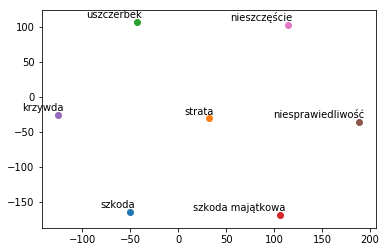

In [23]:
vector_phrases = (
    'szkoda',
    'strata',
    'uszczerbek',
    'szkoda majątkowa',
#     'uszczerbek na zdrowiu',     not in vocabulary
    'krzywda',
    'niesprawiedliwość',
    'nieszczęście'
)

X = [model.wv[phrase] for phrase in vector_phrases]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
for (label, x, y) in zip(vector_phrases, X_tsne[:, 0], X_tsne[:, 1]):
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

plt.show()